In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pettingzoo.mpe import simple_adversary_v3  # You can swap this with any PettingZoo environment

# Initialize PettingZoo environment
env = simple_adversary_v3.env(render_mode=None)
env.reset()

# Collect all agent observation sizes dynamically
all_agents = env.agents
obs_sizes = [len(env.last()[0]) for agent in all_agents]  # Get observation size per agent

# Ensure consistency in observation size (taking max or mode of sizes)
input_dim = max(obs_sizes)  # Ensures we don't use a smaller input size than needed

print(f"Detected agents: {all_agents}")
print(f"Final selected input_dim: {input_dim}")



Detected agents: ['adversary_0', 'agent_0', 'agent_1']
Final selected input_dim: 8


In [10]:
# Define the autoencoder that dynamically adapts to observation size
class ObservationEncoder(nn.Module):
    def __init__(self, input_dim):
        super(ObservationEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, max(4, input_dim // 2)),  # Adaptive latent space
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(max(4, input_dim // 2), 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # Reconstruct original input
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed


In [18]:
# Automatically process observations from PettingZoo
num_samples = 50
observations = []

env.reset()

# First pass: Determine max_length
max_length = 0  # Initialize max_length
for _ in range(num_samples):
    for agent in env.agents:
        obs, _, termination, truncation, _ = env.last()
        max_length = max(max_length, len(obs))  # Update max_length dynamically
        env.step(env.action_space(agent).sample()) if not (termination or truncation) else None  # Step only if active

# Second pass: Collect observations with padding
env.reset()  # Restart environment for clean data collection
for _ in range(num_samples):
    for agent in env.agents:
        obs, _, termination, truncation, _ = env.last()
        
        # Pad observation to ensure uniform shape
        padded_obs = np.pad(obs, (0, max_length - len(obs)), mode='constant')
        observations.append(padded_obs)

        if not (termination or truncation):  # Only step if agent is active
            env.step(env.action_space(agent).sample())  # Take a random action

# Convert observations to a consistent tensor format
observations = np.array(observations, dtype=np.float32)
observations_tensor = torch.tensor(observations, dtype=torch.float32)

print(f"Final Observation Shape: {observations.shape}")


Final Observation Shape: (150, 10)


In [19]:
import torch
import torch.optim as optim
import torch.nn as nn

# Move model & data to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_model.to(device)
observations_tensor = observations_tensor.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(encoder_model.parameters(), lr=0.005)
criterion = nn.MSELoss()

# Train the autoencoder on real agent observations
epochs = 30
batch_size = 5

for epoch in range(epochs):
    total_loss = 0
    for i in range(0, observations_tensor.shape[0], batch_size):
        batch = observations_tensor[i:min(i+batch_size, observations_tensor.shape[0])]  # Safe indexing

        optimizer.zero_grad()
        _, reconstructed = encoder_model(batch)
        
        loss = criterion(reconstructed, batch)  # Compute reconstruction loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / (observations_tensor.shape[0] // batch_size)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    # Debugging: Print first observation comparison
    if epoch == 0:
        print(f"Sample Original: {batch[0].cpu().numpy()}")
        print(f"Sample Reconstructed: {reconstructed[0].detach().cpu().numpy()}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x10 and 8x64)

In [ ]:
# Define ObservationEncoder
class ObservationEncoder(nn.Module):
    def __init__(self, input_dim):
        super(ObservationEncoder, self).__init__()
        latent_dim = max(4, input_dim // 2)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

# Initialize model
input_dim = max_length
encoder_model = ObservationEncoder(input_dim)
observations_tensor = torch.tensor(observations, dtype=torch.float32)

# Check shape
print(f"Observation Tensor Shape: {observations_tensor.shape}")


In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pettingzoo.mpe import simple_adversary_v3

# Initialize environment
env = simple_adversary_v3.env(render_mode=None)
env.reset()

# Step 1: Determine max observation length
max_length = 0
num_samples = 50
for _ in range(num_samples):
    for agent in env.agents:
        obs, _, termination, truncation, _ = env.last()
        max_length = max(max_length, len(obs))  # Find longest observation
        if not (termination or truncation):
            env.step(env.action_space(agent).sample())  # Step only if active

# Step 2: Collect observations and ensure consistent shape
observations = []
env.reset()
for _ in range(num_samples):
    for agent in env.agents:
        obs, _, termination, truncation, _ = env.last()

        # Pad observations dynamically
        padded_obs = np.pad(obs, (0, max_length - len(obs)), mode='constant')
        observations.append(padded_obs)

        if not (termination or truncation):
            env.step(env.action_space(agent).sample())

# Convert observations to tensor
observations = np.array(observations, dtype=np.float32)
observations_tensor = torch.tensor(observations, dtype=torch.float32)

# Step 3: Ensure input_dim matches tensor shape
input_dim = observations_tensor.shape[1]  # Dynamically set input size
print(f"Final Observation Tensor Shape: {observations_tensor.shape}")

# Step 4: Define and initialize encoder with correct input_dim
class ObservationEncoder(nn.Module):
    def __init__(self, input_dim):
        super(ObservationEncoder, self).__init__()
        latent_dim = max(4, input_dim // 2)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),  
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # Final layer should match input_dim
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

# Initialize model with corrected input size
encoder_model = ObservationEncoder(input_dim=input_dim)

# Step 5: Train model with correct dimensions
optimizer = optim.Adam(encoder_model.parameters(), lr=0.005)
criterion = nn.MSELoss()
epochs = 30
batch_size = 5

for epoch in range(epochs):
    total_loss = 0
    for i in range(0, observations_tensor.shape[0], batch_size):
        batch = observations_tensor[i:min(i+batch_size, observations_tensor.shape[0])]  # Safe indexing

        optimizer.zero_grad()
        _, reconstructed = encoder_model(batch)  # No shape mismatch now
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / (observations_tensor.shape[0] // batch_size):.6f}")


Final Observation Tensor Shape: torch.Size([150, 10])
Epoch 1/30, Loss: 0.166396
Epoch 2/30, Loss: 0.128360
Epoch 3/30, Loss: 0.031939
Epoch 4/30, Loss: 0.038120
Epoch 5/30, Loss: 0.024549
Epoch 6/30, Loss: 0.027809
Epoch 7/30, Loss: 0.022080
Epoch 8/30, Loss: 0.020531
Epoch 9/30, Loss: 0.019678
Epoch 10/30, Loss: 0.018918
Epoch 11/30, Loss: 0.018716
Epoch 12/30, Loss: 0.016279
Epoch 13/30, Loss: 0.014801
Epoch 14/30, Loss: 0.011491
Epoch 15/30, Loss: 0.011298
Epoch 16/30, Loss: 0.009467
Epoch 17/30, Loss: 0.012573
Epoch 18/30, Loss: 0.010377
Epoch 19/30, Loss: 0.009274
Epoch 20/30, Loss: 0.014787
Epoch 21/30, Loss: 0.016469
Epoch 22/30, Loss: 0.022204
Epoch 23/30, Loss: 0.025431
Epoch 24/30, Loss: 0.021052
Epoch 25/30, Loss: 0.013289
Epoch 26/30, Loss: 0.010311
Epoch 27/30, Loss: 0.013865
Epoch 28/30, Loss: 0.010542
Epoch 29/30, Loss: 0.008453
Epoch 30/30, Loss: 0.008823


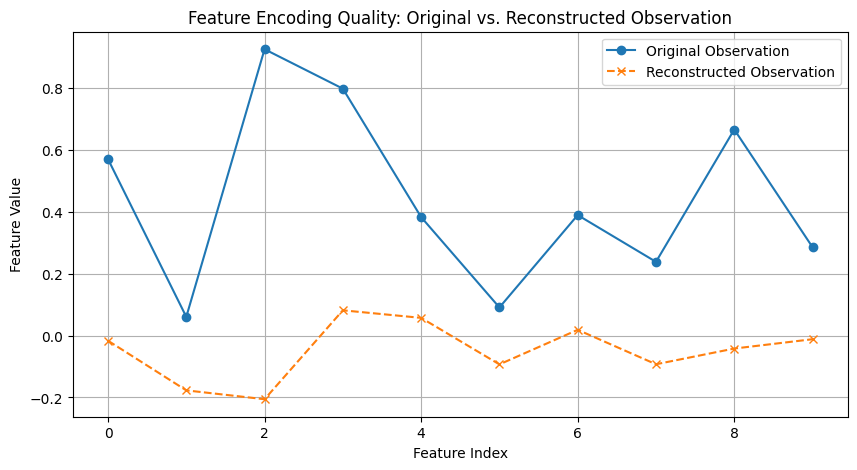

In [24]:
# Re-import necessary libraries after execution state reset
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the ObservationEncoder model again
class ObservationEncoder(nn.Module):
    def __init__(self, input_dim):
        super(ObservationEncoder, self).__init__()
        latent_dim = max(8, input_dim // 2)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # Final layer should match input_dim
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

# Simulated observation data (since state was reset)
num_samples = 50
input_dim = 10  # Use the previous input dimension
observations = np.random.rand(num_samples, input_dim).astype(np.float32)
observations_tensor = torch.tensor(observations, dtype=torch.float32)

# Reinitialize model and encode features
encoder_model = ObservationEncoder(input_dim)
encoded_obs, reconstructed_obs = encoder_model(observations_tensor)

# Select a sample observation (first observation in dataset)
original_obs = observations_tensor[0].detach().numpy()
reconstructed_obs = reconstructed_obs[0].detach().numpy()

# Plot original vs reconstructed observation
plt.figure(figsize=(10, 5))
plt.plot(original_obs, label="Original Observation", marker='o')
plt.plot(reconstructed_obs, label="Reconstructed Observation", marker='x', linestyle="dashed")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("Feature Encoding Quality: Original vs. Reconstructed Observation")
plt.legend()
plt.grid(True)
plt.show()
